In [16]:
from tensorflow.keras.applications import ResNet50, InceptionResNetV2, ResNet101, ResNet101V2

import os
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
import tifffile as tiff
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, UpSampling2D, SpatialDropout2D, concatenate 
from tensorflow.keras.layers import  Activation, Conv2DTranspose, MaxPool2D, BatchNormalization, Dropout, AveragePooling2D
from tensorflow.keras import Model, layers, regularizers 
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import load_model
from keras import layers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras

from tensorflow.keras.initializers import HeNormal
import tensorflow.keras.backend as K

from sklearn.preprocessing import MinMaxScaler

In [2]:
def load_images_and_labels_9_channels(data_path):
    images_path = os.path.join(data_path, 'images')
    labels_path = os.path.join(data_path, 'labels')
    
    scaler = MinMaxScaler()

    images = []
    labels = []
    
    for filename in os.listdir(images_path):
        if filename.endswith('.tif'):  
            image = tiff.imread(os.path.join(images_path, filename))
            # Remove the first 3 RGB channels, use only the remaining 9 channels
            channels_9_image = image[:, :, 3:]  # Channels 4 to 12
            reshaped_image = channels_9_image.reshape(-1, 9)
            normalized_image = scaler.fit_transform(reshaped_image).reshape(128, 128, 9)  # MinMaxScaler normalization
            
            # Load the label
            label_filename = filename.replace('.tif', '.png') 
            label = tf.io.read_file(os.path.join(labels_path, label_filename))
            label = tf.image.decode_png(label, channels=1)
            label = tf.image.resize(label, [128, 128])
            label = tf.cast(label, tf.float32)
            
            images.append(normalized_image)
            labels.append(label)

    images = tf.convert_to_tensor(np.array(images))
    labels = tf.convert_to_tensor(np.array(labels))
    return images, labels

data_path = r"D:\Mohamed Sheriff\Projects\Computer Vision Internship - Cellula Technologies\Water Segementation\Dataset"
images, labels = load_images_and_labels_9_channels(data_path)

print(f"Loaded {len(images)} images with shape {images[0].shape} and {len(labels)} labels with shape {labels[0].shape}")

Loaded 306 images with shape (128, 128, 9) and 306 labels with shape (128, 128, 1)


In [3]:
images = images.numpy()
labels = labels.numpy()



In [4]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=365)
x_test, x_val, y_test, y_val = train_test_split(x_val, y_val, test_size=0.2, random_state=365)


In [5]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape


((244, 128, 128, 9),
 (244, 128, 128, 1),
 (13, 128, 128, 9),
 (13, 128, 128, 1),
 (49, 128, 128, 9),
 (49, 128, 128, 1))

In [6]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    # Flatten the tensors
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice_coeff = (2. * intersection + smooth) / (union + smooth)

    return 1 - dice_coeff

In [7]:
def DeepLabV3Plus(shape):
    inputs = Input(shape)

    ''' Pre-Trained ResNet50'''
    new_first_layer = Conv2D( filters=3, kernel_size=(1,1), padding='same', use_bias=True, name='conv')(inputs)

    # First convolution layer similar to ResNet50 architecture
    conv = Conv2D(32, (7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal')(new_first_layer)
    conv = BatchNormalization(axis=-1, name='custom_conv1_bn')(conv)
    conv = Activation('relu', name='custom_conv1_relu')(conv)
    # conv = Dropout(0.3)(conv) 

    base_model = ResNet50(weights=None, include_top=False, input_tensor=conv)

    
    ''' Extract the required layers from ResNet50'''
    conv1 = base_model.get_layer('conv1_relu').output
    conv2 = base_model.get_layer('conv2_block3_out').output
    conv3 = base_model.get_layer('conv3_block4_out').output
    conv4 = base_model.get_layer('conv4_block6_out').output

    '''Decoding'''
    up5 = UpSampling2D((2,2), interpolation='bilinear')(conv4)
    concat5 = concatenate([up5,conv3], axis = 3)
    conv5 = Conv2D(256,3,padding='same', activation='relu')(concat5)
    conv5 = Conv2D(256,3,padding='same', activation='relu')(conv5)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = Dropout(0.3)(conv5) 

    up6 = UpSampling2D((2,2), interpolation='bilinear')(conv5)
    concat6 = concatenate([up6,conv2], axis = 3)
    conv6 = Conv2D(128,3,padding='same', activation='relu')(concat6)
    conv6 = Conv2D(128,3,padding='same', activation='relu')(conv6)
    # conv6 = BatchNormalization()(conv6)   
    # conv6 = Dropout(0.3)(conv6)

    up7 = UpSampling2D((2,2), interpolation='bilinear')(conv6)
    concat7 = concatenate([up7,conv1], axis =3)
    conv7 = Conv2D(64,3,padding='same', activation='relu')(concat7)
    conv7 = Conv2D(64,3,padding='same', activation='relu')(conv7)
    # conv7 = BatchNormalization()(conv7)

    up8 = UpSampling2D((4,4), interpolation='bilinear')(conv7)

    '''Output Layer'''
    output = Conv2D(1, (1,1), padding='same', name='DeepLabv3')(up8)
    output = Activation('sigmoid')(output)


    ''' Model'''
    model = Model(inputs=inputs, outputs=output)

    '''Compile'''
    lr_schedule = ExponentialDecay( initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss= 'binary_crossentropy', metrics=['accuracy'])

    return model



if __name__=="__main__":
    input_shape = (128,128,9)
    model = DeepLabV3Plus(input_shape)

    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 9  0           []                               
                                )]                                                                
                                                                                                  
 conv (Conv2D)                  (None, 128, 128, 3)  30          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   4736        ['conv[0][0]']                   
                                                                                                  
 custom_conv1_bn (BatchNormaliz  (None, 64, 64, 32)  128         ['conv2d[0][0]']             

In [8]:
model_path = "D:/Mohamed Sheriff/Projects/Computer Vision Internship - Cellula Technologies/Water Segementation/Model/9channels.keras"

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True,
  )

CheckPoint = ModelCheckpoint(filepath= model_path , monitor='val_accuracy' ,save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [9]:
history = model.fit(
    x_train, y_train,
    epochs=100,
    verbose=1,
    batch_size=16,
    validation_data=(x_val, y_val),
     callbacks=[early_stopping , CheckPoint]
)

Epoch 1/100
16/16 [==============================] - 41s 1s/step - loss: 1.7563 - accuracy: 0.7200 - val_loss: 0.3252 - val_accuracy: 0.8572
Epoch 2/100
16/16 [==============================] - 22s 1s/step - loss: 0.3831 - accuracy: 0.8474 - val_loss: 0.3254 - val_accuracy: 0.8686
Epoch 3/100
16/16 [==============================] - 22s 1s/step - loss: 0.3381 - accuracy: 0.8629 - val_loss: 0.3022 - val_accuracy: 0.8720
Epoch 4/100
16/16 [==============================] - 28s 2s/step - loss: 0.3103 - accuracy: 0.8725 - val_loss: 0.3002 - val_accuracy: 0.8750
Epoch 5/100
16/16 [==============================] - 25s 2s/step - loss: 0.3007 - accuracy: 0.8762 - val_loss: 0.3106 - val_accuracy: 0.8770
Epoch 6/100
16/16 [==============================] - 22s 1s/step - loss: 0.3005 - accuracy: 0.8754 - val_loss: 0.3357 - val_accuracy: 0.8734
Epoch 7/100
16/16 [==============================] - 23s 1s/step - loss: 0.2919 - accuracy: 0.8823 - val_loss: 0.2922 - val_accuracy: 0.8767
Epoch 8/100
1

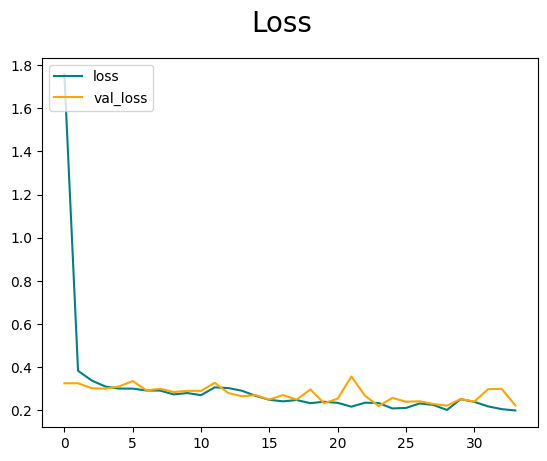

In [10]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

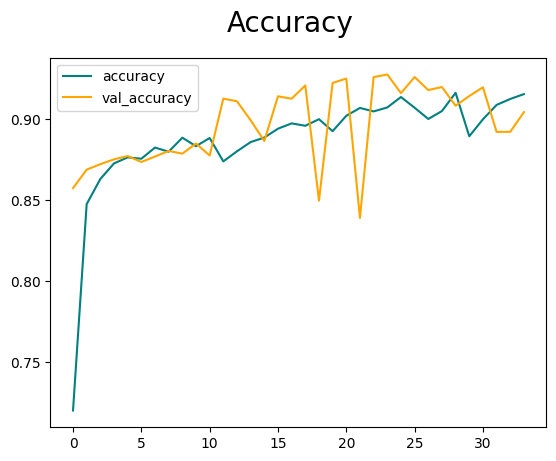

In [11]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [12]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

2/2 [==============================] - 1s 245ms/step - loss: 0.2188 - accuracy: 0.9202


1/1 [==============================] - 1s 798ms/step


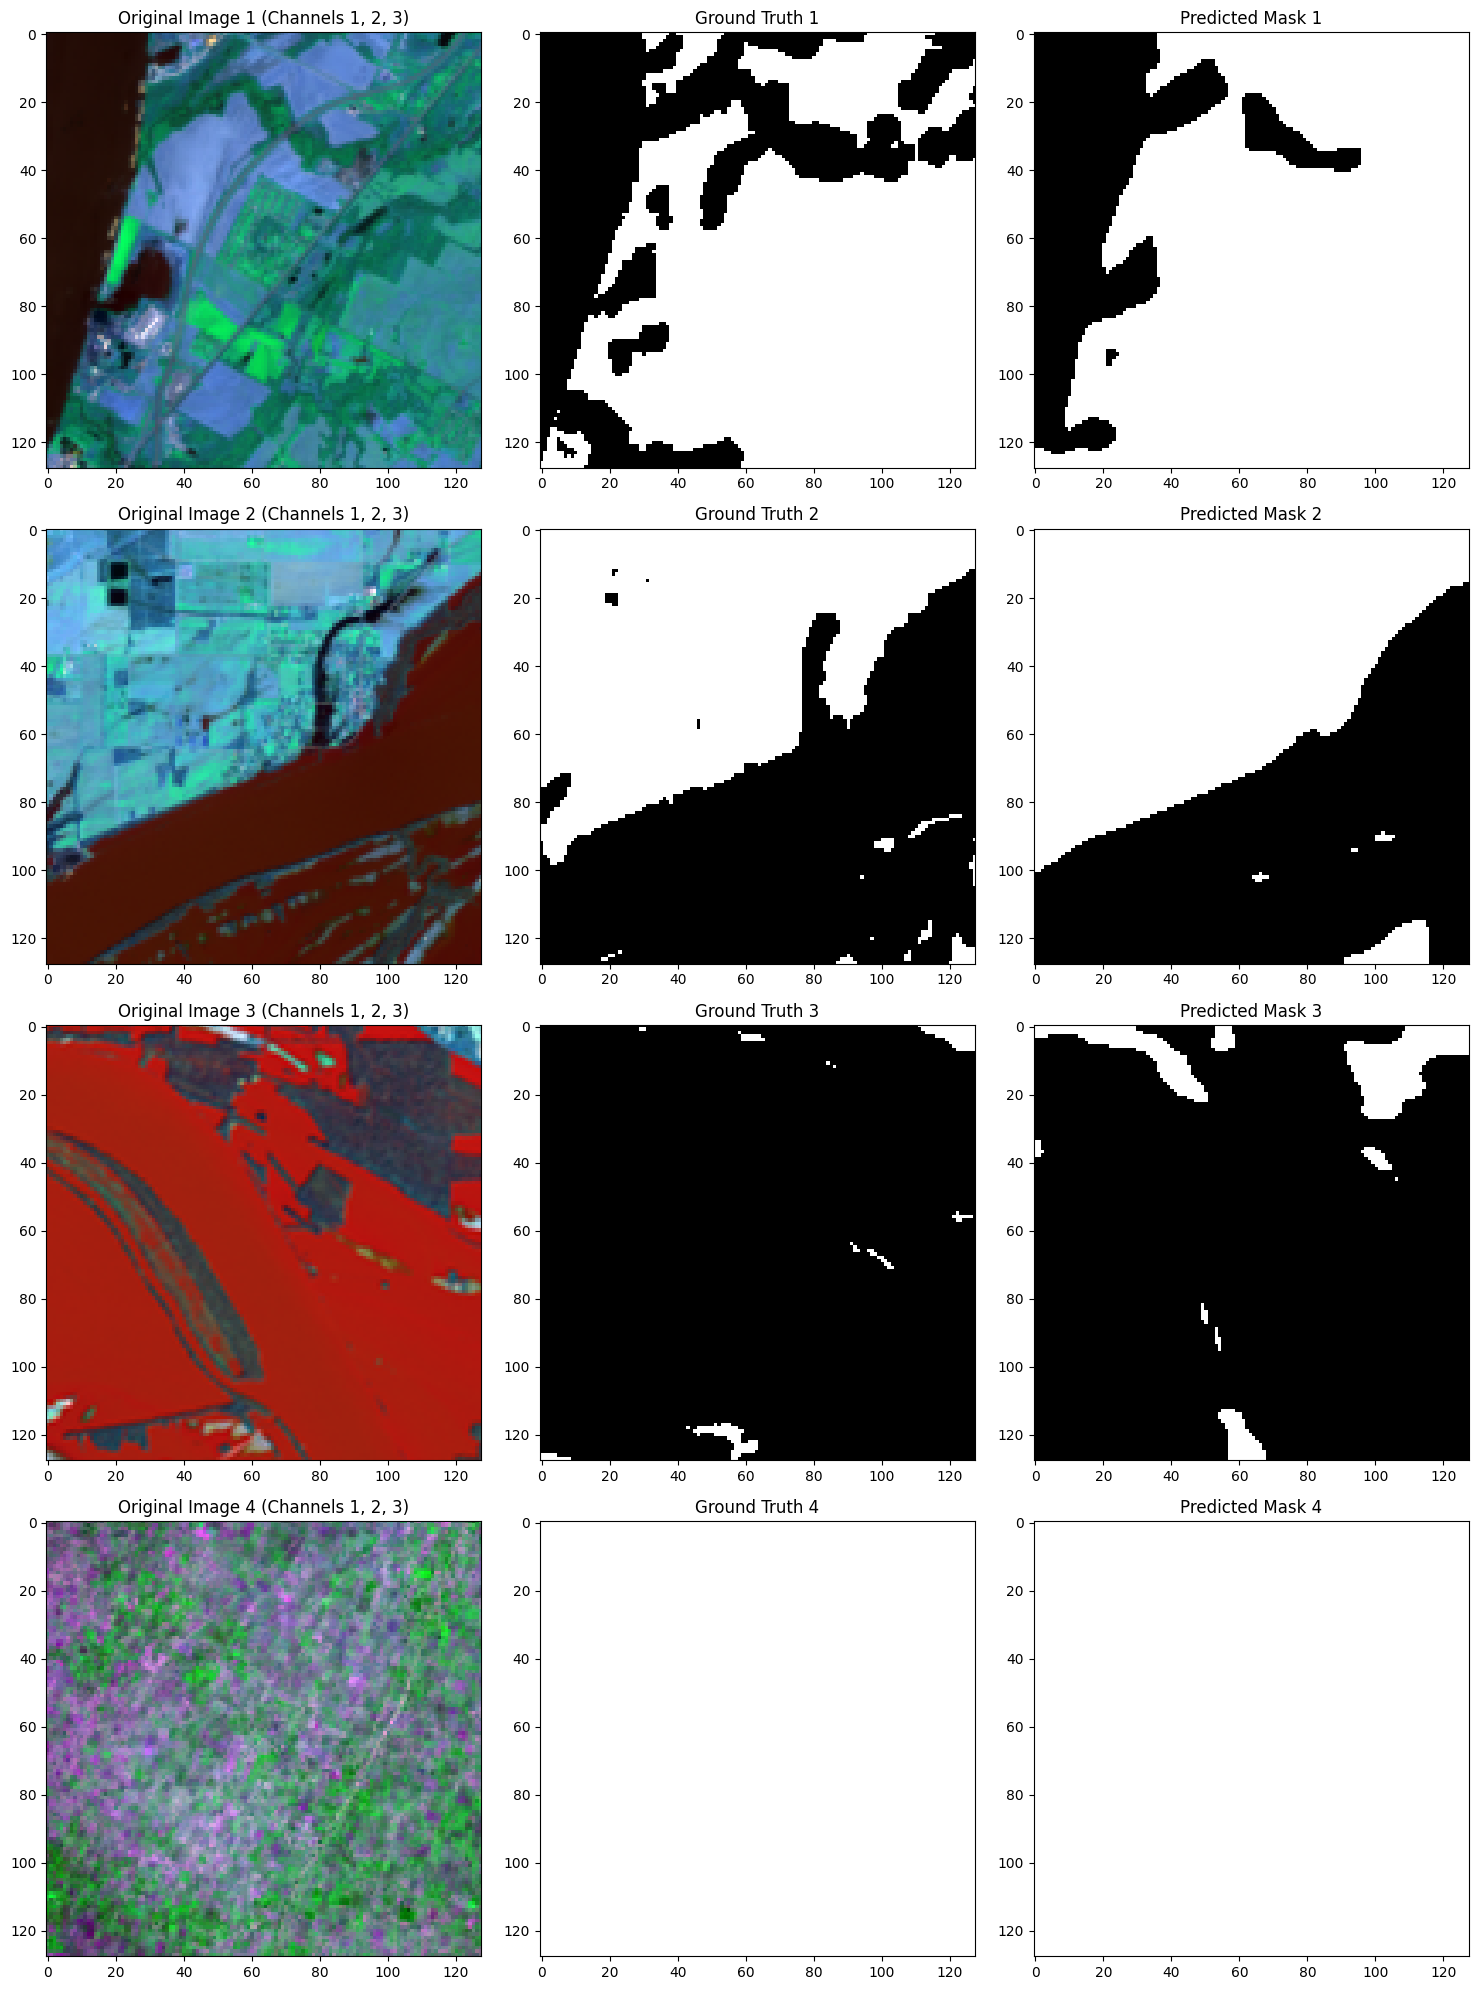

In [19]:
model_path = "D:/Mohamed Sheriff/Projects/Computer Vision Internship - Cellula Technologies/Water Segementation/Model/9channels.keras"
model = load_model(model_path)


# num_images_to_plot = 4
# x_test_samples = x_test[num_images_to_plot:8]  
# y_test_samples = y_test[num_images_to_plot:8]  

num_images_to_plot = 4

# Randomly select indices from the test set
random_indices = random.sample(range(len(x_test)), num_images_to_plot)

# Get random test samples
x_test_samples = np.array([x_test[i] for i in random_indices])
y_test_samples = np.array([y_test[i] for i in random_indices])

predicted_masks = model.predict(x_test_samples)


threshold = 0.5
predicted_masks = np.where(predicted_masks < threshold, 0, 1)


fig, ax = plt.subplots(num_images_to_plot, 3, figsize=(15, 5 * num_images_to_plot))

for i in range(num_images_to_plot):
    # Original Image 
    ax[i, 0].imshow(x_test_samples[i, :, :, :3])  
    ax[i, 0].set_title(f'Original Image {i+1} (Channels 1, 2, 3)')

    # Ground Truth
    ax[i, 1].imshow(y_test_samples[i], cmap='binary') 
    ax[i, 1].set_title(f'Ground Truth {i+1}')

    # Predicted Mask
    predicted_mask = predicted_masks[i].squeeze()  #
    ax[i, 2].imshow(predicted_mask, cmap='binary')
    ax[i, 2].set_title(f'Predicted Mask {i+1}')

# Display the plot
plt.tight_layout()
plt.show()